# 🎲 Monte Carlo

Monte Carlo is a **model-free** RL method — meaning it **doesn’t require transition probabilities or the full MDP model**. It learns purely from experience. ✨

**How it works (high-level flow):**

1. 🎮 **Play the game** — interact with the environment through random trial-and-error to collect rewards.
2. 📈 **Estimate Q-values** — use the collected returns to construct or update the Q-table.
3. 🧭 **Find the optimal policy** — choose the best action for each state based on the Q-table.


In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def render(env):
    state_image = env.render()
    plt.imshow(state_image)
    plt.show()

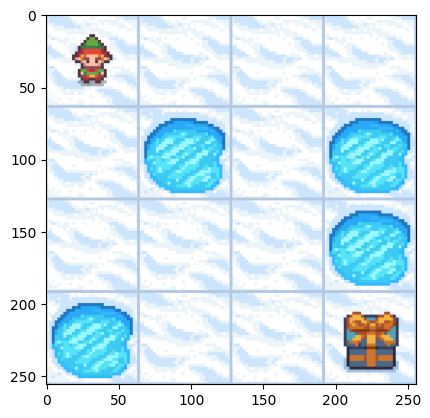

In [3]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")
state, info = env.reset()
render(env)

## Monte Carlo (Every-Visit)

**How it works:**

- 🎮 Play many episodes and collect **(state, action, reward)** sequences.
- 📊 Use these returns to update the **Q-table**.
- 🎯 Select the **best action for each state** based on Q values.

**Example Q-table**

| State | Action 0 | Action 1 | Action 2 |
| ----- | -------- | -------- | -------- |
| 0     | 0.5      | 0.7      | 0.1      |
| 1     | 0.9      | 0.2      | 0.1      |

- For **state 0**, action **1** has the highest Q value.
- For **state 1**, action **0** has the highest Q value.

➡️ **Optimal policy:** `{0: 1, 1: 0}`


In [4]:
def generate_episode(env):
    """Create episode list of (state, action, reward) from 1 run."""
    episode = []
    state, info = env.reset()
    terminated = False
    while not terminated:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode

In [5]:
def monte_carlo(env, n_episodes):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    Q = np.zeros((n_states, n_actions))
    return_sum =  np.zeros((n_states, n_actions))
    return_count = np.zeros((n_states, n_actions))
    
    ## update Q table
    for _ in range(n_episodes):
        episode = generate_episode(env)
        rewards = [r for (_, _, r) in episode]
        for t, (state, action, _) in enumerate(episode):
            return_sum[state, action] += sum(rewards[t:]) # return from step t
            return_count[state, action] += 1
    
    ## average Q values
    nonzero_idx = return_count != 0
    Q[nonzero_idx] = return_sum[nonzero_idx] / return_count[nonzero_idx]
    return Q

In [6]:
def get_optimal_policy(Q):
    """Get the optimal policy from Q tables."""
    return {state: np.argmax(q_values) for state, q_values in enumerate(Q)}

In [7]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")
Q = monte_carlo(env, n_episodes=10000)
policy = get_optimal_policy(Q)
policy

{0: np.int64(0),
 1: np.int64(2),
 2: np.int64(1),
 3: np.int64(0),
 4: np.int64(1),
 5: np.int64(0),
 6: np.int64(1),
 7: np.int64(0),
 8: np.int64(2),
 9: np.int64(1),
 10: np.int64(1),
 11: np.int64(0),
 12: np.int64(0),
 13: np.int64(2),
 14: np.int64(2),
 15: np.int64(0)}

## Evaluation

⚠️ Even after running up to `10,000` episodes, Monte Carlo still doesn’t guarantee that we reach the optimal policy.

⚠️ MC needs lots of samples to converge, and its performance can be unstable depending on exploration and randomness


In [8]:
def evaluate_policy(env, policy, n_episodes=100):
    total_returns = []
    
    for _ in range(n_episodes):
        state, info = env.reset()
        done = False
        G = 0
        
        while not done:
            action = policy[state]
            next_state, reward, terminated, truncated, info = env.step(action)
            G += reward
            state = next_state
            done = terminated or truncated
        
        total_returns.append(G)
    
    return np.mean(total_returns)

In [9]:
env = gym.make("FrozenLake-v1", is_slippery=False, render_mode="rgb_array")

for n_episodes in [100, 500, 1_000, 5_000, 10_000]:
    Q = monte_carlo(env, n_episodes=n_episodes)
    policy = get_optimal_policy(Q)
    score = evaluate_policy(env, policy)
    print(f"{n_episodes=}, {score=}")

n_episodes=100, score=np.float64(0.0)
n_episodes=500, score=np.float64(0.0)
n_episodes=1000, score=np.float64(0.0)
n_episodes=5000, score=np.float64(1.0)
n_episodes=10000, score=np.float64(0.0)
